In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("/content/drive/MyDrive/code/inactivation")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/ベイズ（論文2）/投稿用code/inactivation'

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['font.sans-serif'] = ['Arial'] 
import scipy.optimize
import pandas as pd
import seaborn as sns
import pickle

In [ ]:
#fitting (frequentist) 

#data import
data = pd.read_csv("data/frequentism_fitting.csv")
t = data['TIME']
R = data['Ratio']

#fitting
parameter_initial = np.array([1.4,1.4])
def func(t, α, β):
    return -((t/α)**β)
parameter_optimal, covariance= scipy.optimize.curve_fit(func, t, R, p0=parameter_initial)
y = func(t, parameter_optimal[0], parameter_optimal[1])
print("scale parameter (α) =", format(parameter_optimal[0]))
print("shape parameter (β) =", format(parameter_optimal[1]))
RMSE = np.sqrt(mean_squared_error(R,y))
print("RMSE= ", format(RMSE))

#result of fitting
T = np.arange(0,6,0.05)
y = 4.9-((T/parameter_optimal[0])**parameter_optimal[1])


scale parameter (α) = 1.5848891730097403
shape parameter (β) = 1.2615817935127758
RMSE=  0.17570346625247338


In [ ]:
#fitting by bayesian 

with open('data/model-inactivation.pkl','rb') as f:
    model = pickle.load(f)
with open('data/result-inactivation.pkl','rb') as g:
    fit_nuts = pickle.load(g)
scale = fit_nuts['a'] #scale parameter(δ)
shape = fit_nuts['b'] #shape parameter(p)
N0 = 79000 #initial cell number

#time
T0 =[]
for n in range(61):
    t0 = n*0.1
    T0.append(t0)
T1 = pd.DataFrame(T0)

#confidence interval
y_conf_int = np.zeros((len(scale),len(T0)))
for i in range(len(scale)):
    for j in range(len(T0)):
        y_conf_int[i,j] = N0*(10**(-((np.array(T0[j])/scale[i])**(shape[i]))))
y_conf_int_975 = np.percentile(y_conf_int, 2.5, axis=0)
y_conf_int_025 = np.percentile(y_conf_int, 97.5, axis=0)
y_conf_int_500 = np.percentile(y_conf_int, 50.0, axis=0)
y_conf = np.log10(y_conf_int)
y_conf_975 = np.percentile(y_conf, 2.5, axis=0)
y_conf_025 = np.percentile(y_conf, 97.5, axis=0)
y_conf_500 = np.percentile(y_conf, 50.0, axis=0)

#predicted interval
y_pred_int = np.zeros((len(scale),len(T0)))
for i in range(len(scale)): 
    for j in range(len(T0)):    
        y_pred_int[i,j] = np.random.poisson(N0*(10**(-((np.array(T0[j])/scale[i])**(shape[i])))))
y_pred_int_975 = np.percentile(y_pred_int, 2.5, axis=0)
y_pred_int_025 = np.percentile(y_pred_int, 97.5, axis=0)
y_pred_int_500 = np.percentile(y_pred_int, 50.0, axis=0)
y_pred = np.log10(y_pred_int)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

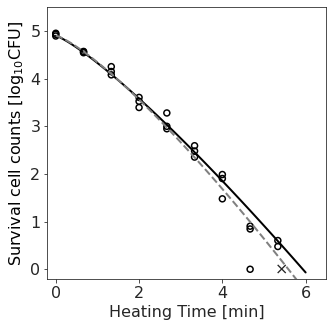

In [ ]:
#graph
#plot+frequentism+bayes
data2 = pd.read_csv('data/bayesian_fitting.csv')
x = data2['TIME']
y1 = data2['Nt']
y1 = np.log10(y1)
fig = plt.figure()
plt.figure(figsize=(5,5))
sns.set_style(style='ticks')
plt.xlabel("Heating Time [min]", size=16)
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')    
plt.xticks([0,2,4,6])
plt.xlim(-0.2,6.5)
plt.ylim(-0.2,5.5)
plt.plot(T, y, color="gray",linestyle='dashed',lw=2,zorder=2)     
plt.text(5.25, -0.1, '×', fontsize=16)
plt.plot(T0,y_conf_500, linestyle = 'solid', zorder=1, color='k', lw=2.0)
plt.scatter(x, y1, facecolors='None', edgecolors='k',linewidths=1.5) 